In [1]:
from comet_ml import Experiment

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"



In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm as tqdm
import itertools

import seaborn as sns
from IPython.display import clear_output


from rich_utils import data_preprocessing



%matplotlib inline


In [3]:
PARTICLE_TYPE = 'kaon'
MODEL_NAME = "NF_{}_test_spline_conditional".format(PARTICLE_TYPE)

BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 64

N_VAL = int(1e6)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_LAYERS = 5

## Data

In [4]:
data_train, data_val, scaler = data_preprocessing.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)

Reading and concatenating datasets:
	../data/data_calibsample/kaon_+_down_2016_.csv
	../data/data_calibsample/kaon_-_up_2016_.csv
	../data/data_calibsample/kaon_+_up_2016_.csv
	../data/data_calibsample/kaon_-_down_2016_.csv
	../data/data_calibsample/kaon2_+_up_2016_.csv
	../data/data_calibsample/kaon2_-_down_2016_.csv
	../data/data_calibsample/kaon2_+_down_2016_.csv
	../data/data_calibsample/kaon2_-_up_2016_.csv
scaler train sample size: 2800000
scaler n_quantiles: 100000, time = 2.4983952045440674
converting dtype to <class 'numpy.float32'>


In [5]:
from rich_utils import data_processing

train_loader = data_processing.getLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = data_processing.getLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel, RandomPerm
)
from nflib.spline_flows import NSF_AR, NSF_CL


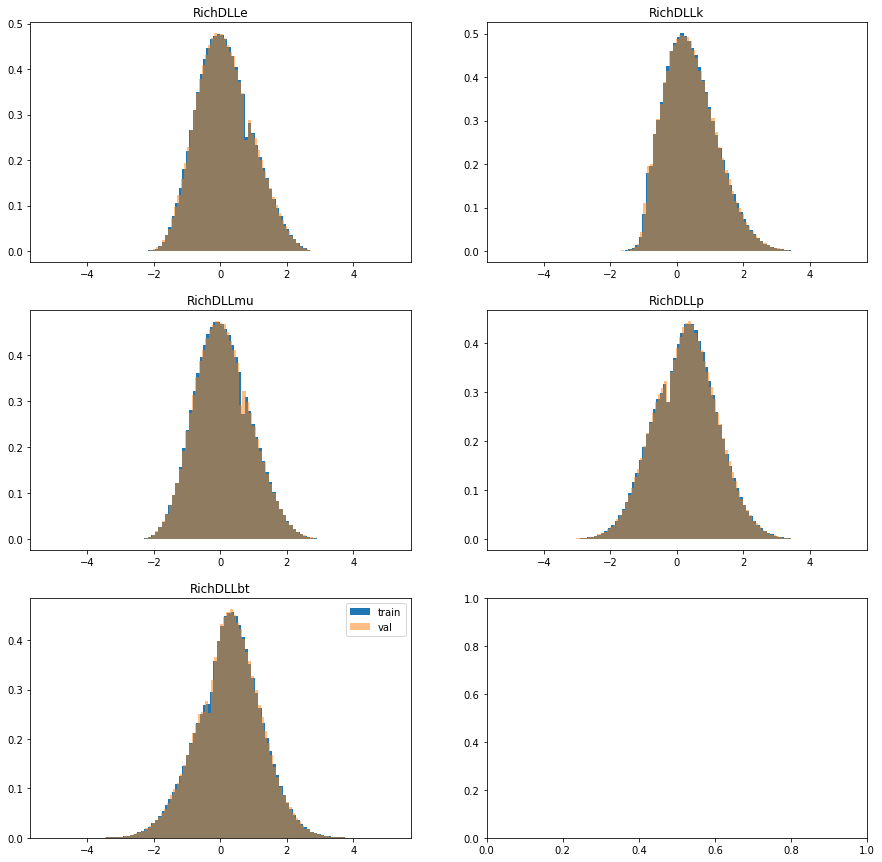

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    _, bins, _ = ax.hist(data_train[data_preprocessing.dll_columns].iloc[:, INDEX],
                         bins=100,
                         label="train",
                         density=True,
                         weights=data_train[data_preprocessing.weight_col].values.reshape(-1))
    ax.hist(data_val[data_preprocessing.dll_columns].iloc[:, INDEX],
                         bins=100,
                         label="val",
                         density=True,
                         alpha=0.5,
                         weights=data_val[data_preprocessing.weight_col].values.reshape(-1))
    ax.set_title(data_preprocessing.dll_columns[INDEX])

ax.legend()
plt.show()

In [8]:
from nflib.nets import ResidualNet

## Model

In [9]:
dim = data_preprocessing.y_count

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))

flows = []
for i in range(NUM_LAYERS):
    flows.append(NSF_AR(dim=dim, K=8, B=3,
                        hidden_dim=32,
                        base_network=ResidualNet,
                        context=len(data_preprocessing.raw_feature_columns),
                        num_blocks=3))
    flows.append(ActNorm(dim=dim))
model = NormalizingFlowModel(prior, flows).to(device)
        
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))        


number of params:  166705


In [10]:
batch = next(iter(train_loader))
x, weight, dll = [i.to(device) for i in batch]
zs, prior_logprob, log_det = model(dll, context=x)


In [12]:
model.sample(BATCH_SIZE, context=x)[0].shape

torch.Size([1000, 5])

## Train

In [13]:
LOGDIR = "./log"

TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 5


In [14]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="rich2019", workspace="maximartemev", disabled=False)


COMET INFO: old comet version (3.0.2) detected. current: 3.1.0 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/rich2019/72fd32694ab04290a4741d580f47affb



In [15]:
def plot_compare(real, generated, weights, title):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for INDEX, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
        _, bins, _ = ax.hist(real[:, INDEX],
                             bins=100,
                             label="data",
                             density=True,
                             weights=weights)
        ax.hist(generated[:, INDEX],
                bins=bins,
                label="generated",
                alpha=0.5,
                density=True,
                weights=weights)
        ax.legend()
        ax.set_title(data_preprocessing.dll_columns[INDEX])
    plt.title(title)


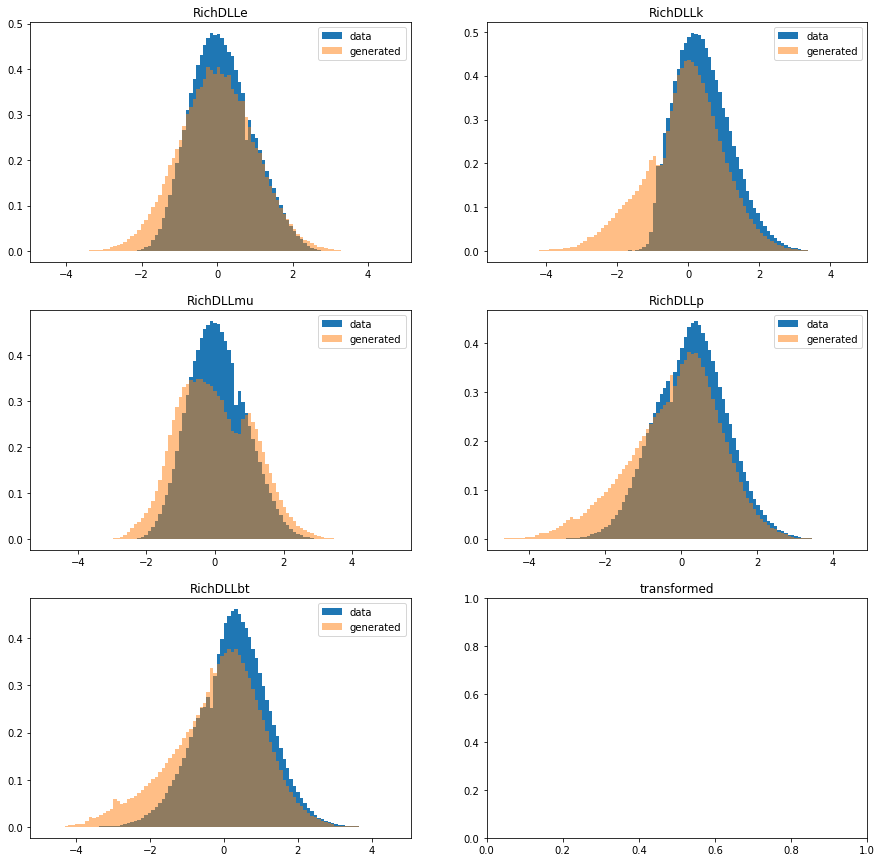

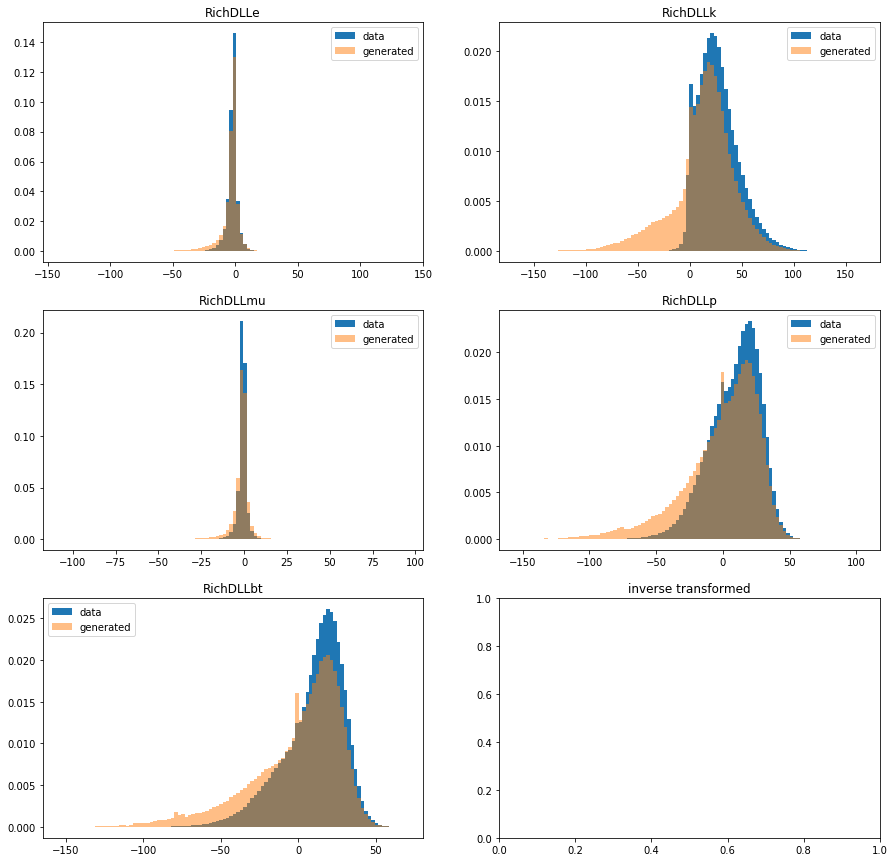

  0%|          | 61/100000 [24:43:48<39940:58:06, 1438.75s/it]

  0%|          | 62/100000 [25:06:20<39217:57:21, 1412.72s/it]

  0%|          | 63/100000 [25:28:51<38703:38:38, 1394.21s/it]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 65/100000 [26:13:57<38118:11:17, 1373.15s/it]

In [ ]:
model.train()
for epoch in tqdm(range(TOTAL_ITERATIONS), position=0, leave=True):
    for batch_ind, batch in tqdm_notebook(enumerate(train_loader), total=len(train_loader), leave=False):
        step = epoch * len(train_loader) + batch_ind
        x, weight, dll = [i.to(device) for i in batch]
        zs, prior_logprob, log_det = model(dll, context=x)
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob) # NLL
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        experiment.log_metric('loss', loss.item(), step=step)
        
    if epoch % VALIDATION_INTERVAL == 0:
        model.eval()
        clear_output(False)
        x = data_val[data_preprocessing.raw_feature_columns].values
        dll = data_val[data_preprocessing.dll_columns].values
        weights = data_val[data_preprocessing.weight_col].values.reshape(-1)
        generated = torch.cat([model.sample(BATCH_SIZE, context=x_batch.to(device))[-1].cpu().detach()
                               for x_batch, _, _ in tqdm_notebook(val_loader, desc='val loop')], dim=0)
        plot_compare(dll, generated, weights, title='transformed')
        experiment.log_figure('transformed', step=epoch)
        plt.show()

        inversed_real = scaler.inverse_transform(np.column_stack([dll, x]))[:, :dll.shape[1]]
        inversed_generated = scaler.inverse_transform(np.column_stack([generated, x]))[:, :generated.shape[1]]

        plot_compare(inversed_real, inversed_generated, weights, title='inverse transformed')
        experiment.log_figure('inverse transformed', step=epoch)
        plt.show()

experiment.end()

In [ ]:
1

In [ ]:
torch.save({MODEL_NAME+'.state_dict': model.state_dict()}, LOGDIR)
from sklearn.externals import joblib
os.makedirs('./preprocessors', exist_ok=True)
joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")


### Evaluate with classifier

In [ ]:
pred_dlls_ = []
for batch in tqdm(val_loader, position=0, leave=True):
    x, weight, dlls = [i.to(device) for i in batch]
    pred_dlls_.append(model.sample(BATCH_SIZE)[-1].cpu().detach().numpy())

In [ ]:
pred_dlls = np.concatenate(pred_dlls_, axis=0)
pred_data = np.concatenate([pred_dlls, data_val.values[:, data_preprocessing.y_count:-1]], axis=1)

pred_data_inversed = scaler.inverse_transform(pred_data)
val_data_inversed = scaler.inverse_transform(data_val.iloc[:, :-1])


In [ ]:
val_data_inversed_ = pd.DataFrame(val_data_inversed,
                                  columns=data_val.columns[:-1])
for ind, col in enumerate(data_preprocessing.dll_columns):
    val_data_inversed_["predicted_"+col] = pred_data_inversed[:, ind]
val_data_inversed_['probe_sWeight'] = data_val['probe_sWeight']

In [ ]:
class Wrapper:
    def __init__(self, data):
        self.test = data

wrap = lambda x, particle: {particle: Wrapper(x)}

In [ ]:
from rich_utils.model_testing import eval_model

scores, bins = eval_model(PARTICLE_TYPE, wrap(val_data_inversed_, PARTICLE_TYPE))

In [ ]:
print("Particle: {}, global test score: {} +- {}".format(PARTICLE_TYPE,
                                                         scores.mean(axis=0)[0][1],
                                                         scores.std(axis=0)[0][1]))